# Overview

This demonstrates a simple pipeline for applying VWAM to brain data. To do this, we use the video dataset from the [2021 Algonauts Challenge](http://algonauts.csail.mit.edu/2021/challenge.html). This consists of 1000 video clips and corresponding fMRI responses. This is not a *SUPER* high quality dataset--you would likely get better results using other, larger datasets, like the [Natural Scenes Dataset](https://naturalscenesdataset.org/) or [BOLD 5000](https://openneuro.org/datasets/ds001499/versions/1.3.0). However, this dataset is easy to download and will work for our demo purposes.

You can use other datasets, including images, videos, or even audio or text (though these will require a different DNN model). You could even use a different brain measurement technique, though this will likely require different preprocessing.

See our [full paper](https://arxiv.org/abs/2506.04379) for more details about the data and methods we used.

In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import Inception_V3_Weights as model_weights
from torchvision.models import inception_v3 as model_init
from tqdm import tqdm
from scipy.stats import zscore
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.scoring import correlation_score
from vwam.utils import VWAMModel, linear_decorrelate_color, show_imgs
from algonauts_utils import load_video, load_roi_data

## DNN Feature Extraction

First, we extract and downsample DNN activations for each of the video clips. Here, we use a pretrained image classification model, InceptionV3, and extract activations from all layers of the model in responses to each video frame. We then average over activations to each frame to get averaged features for each video clip, matching the fMRI data (1 set of responses per video).

In [2]:
# Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float32
model_name = 'inception_v3'
subject_id = 'sub03'
roi = 'PPA'
features_file = 'InceptionV3_activations.npy'
weights_file = f'{subject_id}_{roi}_weights.npy'

In [3]:
# Initialize model
base_model = model_init(weights=model_weights.DEFAULT).to(DEVICE).to(DTYPE).eval()
dnn_model = VWAMModel(base_model)
dnn_model.choose_layers(depth=1, filter_strings=['dropout', 'AuxLogits'])

# Define preprocessing
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Check for existing features
if not os.path.exists(features_file):
    print("Features not found, extracting from videos...")
    all_features = []
    
    # Process all 1000 videos
    for video_idx in tqdm(range(1000), desc="Processing videos"):
        # Load and process video
        frames = load_video(video_idx)
        frames = torch.tensor(frames, dtype=DTYPE, device=DEVICE).permute(0, 3, 1, 2)
        frames = frames.float() / 255.0  # Normalize to [0,1]
        frames = preprocess(frames)
        
        # Get activations
        with torch.no_grad():
            dnn_model.forward(frames)
            features = dnn_model.activations_flat.detach().cpu()
        
        # Average over frames to get one feature vector per video
        features = features.mean(0)
        all_features.append(features)
    
    # Stack features from all videos
    features = torch.stack(all_features)
    np.save(features_file, features.numpy())
else:
    print("Loading existing features...")
    features = np.load(features_file)

Loading existing features...


## Regression Model Fitting

Next, we use regularized linear regression to estimate a linear mapping between the downsampled DNN features and responses of individual 'voxels' in our fMRI data. We then average regression weights over voxels with a Region of Interest (ROI).

In [5]:
# Check for existing weights
if not os.path.exists(weights_file):
    print("Weights not found, fitting model...")
    # Load and process brain data
    brain_data = load_roi_data(subject_id, roi)
    brain_data = np.nan_to_num(zscore(brain_data, axis=0))
    
    # Fit ridge regression
    alphas = np.logspace(0, 10, 15)
    regression_model = KernelRidgeCV(
        alphas=alphas,
        kernel='linear',
        fit_intercept=False,
        cv=5,
        solver_params={'score_func': correlation_score}
    )
    
    # Fit and save weights
    regression_model.fit(features, brain_data)
    print(f"Mean CV correlation: {np.nanmean(regression_model.cv_scores_):.3f}")
    weights = regression_model.get_primal_coef()
    np.save(weights_file, weights)
else:
    print("Loading existing weights...")
    weights = np.load(weights_file)

# Process weights
weights = np.mean(weights, axis=1)  # Average over voxels
weights /= np.linalg.norm(weights)  # Normalize
weights = torch.tensor(weights, device=DEVICE, dtype=DTYPE)

Weights not found, fitting model...
Mean CV correlation: 0.183


## Activation Maximization / Feature Visualization

Finally, we use feature visualization to generate images that are predicted via our regression model to yield very high responses in the selected brain region. This involves iteratively computing predicted ROI responses to an image, using gradients to compute updates to that image, then applying these updates so that the image should drive even strong responses in the region.

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/matthew/anaconda3/envs/pomlab/lib/python3.12/site-packages/vwam/utils.py:436: UserWarning: downsample_activations has been called, but self._downsamplers has not been defined. Running choose_downsamplers with default values.
  warnings.warn('downsample_activations has been called, but self._downsamplers has not been defined. Running choose_downsamplers with default values.')
100%|██████████| 1000/1000 [00:25<00:00, 38.53it/s, loss per render=-334]


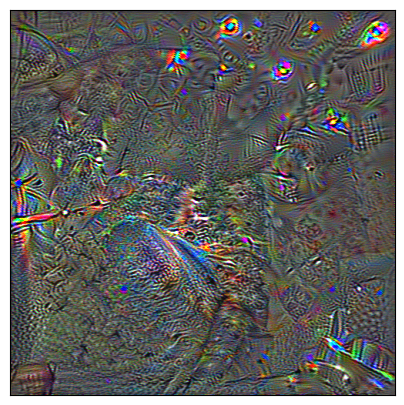

In [6]:
# Define invariance transforms
invariance_transforms = transforms.Compose([
    transforms.RandomCrop((500,500), padding=5),
    transforms.RandomRotation([-5,5]),
    transforms.RandomResizedCrop((500,500), scale=(.95,1.05), ratio=(1,1,1)),
    transforms.RandomCrop((500,500), padding=3),
])

# Setup optimization
n_iterations = 1000
image_shape = (1, 3, 500, 500)
fspace = torch.randn(image_shape, dtype=torch.complex64, device=DEVICE) + torch.fft.fft2(torch.full(image_shape, 140/255, dtype=DTYPE, device=DEVICE))
fspace.requires_grad_(True)
optimizer = torch.optim.Adam([fspace], lr=2.5e0)

# Optimization loop
iterator = tqdm(range(n_iterations))
for i in iterator:
    optimizer.zero_grad()
    
    # Generate images
    images = torch.abs(torch.fft.ifft2(fspace))
    
    # Apply color decorrelation
    images = linear_decorrelate_color(images)
    
    # Forward pass and loss computation
    outputs = dnn_model(preprocess(invariance_transforms(images)))
    activations = dnn_model.activations_flat
    loss = -torch.sum(weights * activations)
    
    # Update progress
    iterator.set_postfix({'loss per render': loss.item()/len(fspace)})
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

# Show the generated images
show_imgs(images)

Here, we optimized the image for predicted responses in the Parahippocampal Place Area (PPA), which is known to respond to visual scenes. What do you see? Does the generated image contain features you would expect to drive responses in the selected region?

Consider trying other regions, including:
- V1: edges
- V4: textures
- FFA: faces
- EBA: bodies

You can also try more complex objectives, such as *minimizing* responses in a ROI (negate the weights vector), or *contrasting* two or more ROIs (subtract ROI weights from each other).

Can you think of anything else that would be interesting to try? This general approach of 'extract DNN features -> fit regression model -> apply interpretability tool' is designed to be flexible to different *interpretability tools*. This means that other approaches, such as occlusion mapping, gradient analyses, or other feature visualization variants, could also be applied to the brain. If you try any variants of this approach, feel free to let us know!